In [1]:
import matplotlib.pyplot as plt
import pygame
import numpy as np
import random
import copy
import cma
import pickle
import functools
import operator

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
##### CONSTANTES
k = 30
directions = [6,8,10,12,30,40,60]
k_dir =len(directions)
N_in = k + 2 + 2 
N1 =10
N2 = 10
N_out = k + k_dir
f = 0.3
rb = 3
rt = 20
m = 1
g = 9.81
best_distance = 300
nb_dep = 200

angles = [i * 2*np.pi/k for i in range(k)]
print(angles)

ratio_distance = 0.5
ratio_angle = 100


num_elites = 3
nbre_mouvements = 50
nb_gen = 20
nb_pop = 100
mutation_rate = 2/(nbre_mouvements*2)
v_max = 10

[0.0, 0.20943951023931953, 0.41887902047863906, 0.6283185307179586, 0.8377580409572781, 1.0471975511965976, 1.2566370614359172, 1.4660765716752369, 1.6755160819145563, 1.8849555921538759, 2.0943951023931953, 2.3038346126325147, 2.5132741228718345, 2.7227136331111543, 2.9321531433504737, 3.1415926535897927, 3.3510321638291125, 3.5604716740684323, 3.7699111843077517, 3.979350694547071, 4.1887902047863905, 4.39822971502571, 4.607669225265029, 4.817108735504349, 5.026548245743669, 5.235987755982989, 5.445427266222309, 5.654866776461628, 5.8643062867009474, 6.073745796940267]


In [3]:
###### FONCTIONS UTILES

def produitvectoriel(vect1,vect2):
    return (vect1[0]*vect2[1] - vect1[1]*vect2[0])

def produitscalaire(vect1,vect2):
    return(vect1[0]*vect2[0] + vect1[1]*vect2[1])

def draw_circle(matrice,i,j,r, colour):
    for x in range(len(matrice)):
        for y in range(len(matrice[x])):
            if abs((x-i)**2 + (y-j)**2) <=r**2:
                matrice[x,y] = colour

def get_line(start, end):
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1
    dy = y2 - y1
    error = int(dx / 0.5)
    ystep = 1 if y1 < y2 else -1
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
    if swapped:
        points.reverse()
    return points


def draw_segment(matrice, start,end):
    points = get_line(start, end)
    shape = np.shape(matrice)
    for i in points:
        if i[0]<shape[0] and i[1] < shape[1]:
            matrice[i[0],i[1]] = 0.7
    


In [4]:
##### CLASSE JOUEUR
class Joueur:  
    def __init__(self, array_trou,array_balle,obstacles, nbre_mouvements):
        self.is_best = False
        self.fitness = 0
        self.liste_mouvements = []
        self.liste_emplacements = [array_balle]
        self.nn = Simple_nn(N_in,N1,N_out)
            
    def evaluate_fitness(self):
        a = best_distance
        distance = np.sqrt((self.partie.trou.position[0] - self.partie.balle.position[0])**2 + (self.partie.trou.position[1] - self.partie.balle.position[1])**2 ) 
        if self.partie.reached_goal:
            #print("victoire")
            self.fitness = 100
        elif (not self.partie.is_dead): 
            #print(distance)
            self.fitness = 10000000/(distance)**4
        else:
            self.fitness = -5000/self.partie.nb_coups
        return float(self.fitness)
            
        
    def faire_partie(self,array_balle):
        self.partie = Partie(array_balle,array_trou,obstacles)
        for i in range(nb_dep):
            if self.partie.reached_goal:
                for i in range(nb_dep - i):
                    self.liste_emplacements.append(self.liste_emplacements[-1])
                self.evaluate_fitness()
                return
            
            if self.partie.is_dead:
                for i in range(nb_dep - i):
                    self.liste_emplacements.append(self.liste_emplacements[-1])
                self.evaluate_fitness()
                return
            
            else:
                a = self.partie.distances()
                b = np.array([self.partie.balle.position[0],self.partie.balle.position[1],self.partie.trou.position[0],self.partie.trou.position[1]]) 
                c = np.concatenate((a, b)).flatten()
                y = self.nn.compute(c)
                self.liste_mouvements.append(y)
                a = self.partie.deplacement(y)
                self.liste_emplacements.append(a)
        return
        
        
        
    
                

In [5]:
###### CLASSE POPULATION

class Population:
    def __init__(self, solutions, arraytrou, obstacles, arrayballe = None):
        #if arrayballe == None:
         #   arrayballe = [np.ceil(random.random()*599+100),np.ceil(random.random()*599+100)]
        #self.array_balle = arrayballe
        self.liste_joueur = []
        self.solutions = solutions
        self.nb_not_dead = 0
        for i in range(len(solutions)):
            if arrayballe == None:
                array_balle = [np.ceil(random.random()*599+100),np.ceil(random.random()*599+100)]
                joueur = Joueur(arraytrou,array_balle,obstacles, nbre_mouvements)
                joueur.nn.transform(solutions[i])
                joueur.faire_partie(array_balle)
                joueur.evaluate_fitness()
                self.liste_joueur.append(joueur)
            else:
                joueur = Joueur(arraytrou,arrayballe,obstacles, nbre_mouvements)
                joueur.nn.transform(solutions[i])
                joueur.faire_partie(arrayballe)
                joueur.evaluate_fitness()
                self.liste_joueur.append(joueur)
                
            if (not joueur.partie.is_dead):
                self.nb_not_dead += 1
                
    def total_transform(self, arraytrou, obstacles, arrayballe = [np.ceil(random.random()*599+100),np.ceil(random.random()*599+100)]):
        self.liste_joueur = []
        self.nb_not_dead = 0
        for i in range(len(self.solutions)):
            joueur = Joueur(array_trou,arrayballe,obstacles, nbre_mouvements)
            joueur.nn.transform(self.solutions[i])
            joueur.faire_partie(arrayballe)
            joueur.evaluate_fitness()
            self.liste_joueur.append(joueur)
            if (not joueur.partie.is_dead):
                self.nb_not_dead += 1
        
        
    def to_array(self):
        imax = 0 
        for i in range(len(self.liste_joueur)):
            if self.fitness_function(i) > self.fitness_function(imax):
                imax = i
        return self.liste_joueur[imax].nn.to_array()
    
    def to_array_golbal(self):
        l = []
        for i in range(len(self.liste_joueur)):
            l.append(self.liste_joueur[i].nn.to_array())
        return l
        
        
    def fitness_function(self,i):
        joueur = self.liste_joueur[i]
        return joueur.fitness
        
    def print_partie(self,arraytrou, obstacles, nbre_mouvements):
        pygame.init()
        win = pygame.display.set_mode((800,800))
        pygame.display.set_caption("Le mini-golf de l'enfer")
        x_trou = int(arraytrou[0])
        y_trou = int(arraytrou[1])
        win.fill((0,128,0))
        for i in obstacles:
            pygame.draw.line(win, (0,0,0), i.depart, i.arrivee,10)

        run = True
        couleur = self.generer_couleur()
        for i in range(nbre_mouvements): 
            pygame.time.delay(1)
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    run = False
            pygame.draw.circle(win, (0,0,0), (x_trou,y_trou), rt)
            for obs in obstacles:
                pygame.draw.line(win, (0,0,0), obs.depart, obs.arrivee,10)
            ind_coul = 0
            for j in self.liste_joueur:
                pygame.draw.circle(win, couleur[ind_coul], (int(j.liste_emplacements[i][0]),int(j.liste_emplacements[i][1])), rb)
                pygame.display.update()
                ind_coul += 1
            win.fill((0,128,0))
        print("fin")
        pygame.display.flip()
        pygame.quit()
        
    def generer_couleur(self):
        couleur = []
        for i in range(nb_pop):
            couleur.append((random.randint(0,250),random.randint(0,250),random.randint(0,250)))
        return couleur

In [6]:
###### CLASSE NEURAL NETWORK
class Simple_nn:
    def __init__(self, N_in, N1,N_out):
        self.fitness = 0
        self.l1 = np.random.random((N_in,N1))
        self.l2 = np.random.random((N1,N2))
        self.out = np.random.random((N2,N_out))
    
    def compute(self,inputs):
        x = np.dot(self.l1,np.reshape(inputs,(N_in,1)))
        x = np.dot(self.l2, x)
        x = np.dot(self.out,x)
        x = x/(N_in*N1)
        x = x.flatten()
        x = np.abs(x)
        v = x[0,0]
        v = directions[ np.argmax(x[0,:k_dir]) ]
        angle = angles[ np.argmax(x[0,k_dir:]) ]
        return ([v, angle])
    
    def to_array(self):
            array = []
            for i in self.l1:
                array.append(np.asarray(i))
            for i in self.l2:
                array.append(np.asarray(i))
            for i in self.out:
                array.append(np.asarray(i))
                a = functools.reduce(operator.iconcat, array, [])
            return functools.reduce(operator.iconcat, a, [])
        
    def transform(self, genes):
        layers = [self.l1.flatten(),self.l2.flatten(),self.out.flatten()]
        L = 0
        j = 0
        for i in range(len(genes)):
            if j >= len(layers[L]):
                L += 1
                j = 0
            layers[L][j] = genes[i]
            j += 1
        self.l1 = np.reshape(np.asmatrix(layers[0]),(N1,N_in))
        self.l2 = np.reshape(np.asmatrix(layers[1]),(N2,N1))
        self.out = np.reshape(np.asmatrix(layers[2]),(N_out,N2))  

In [7]:
#### CLASSE SEGMENT

class Segment:
    def __init__(self,array1,array2):
        self.depart = array1
        self.arrivee = array2
        
    def cross(self , segment):
        ab = [self.arrivee[0] - self.depart[0] , self.arrivee[1] - self.depart[1]]
        apbp = [segment.arrivee[0] - segment.depart[0] , segment.arrivee[1] - segment.depart[1]]
        abp = [segment.arrivee[0] - self.depart[0], segment.arrivee[1] - self.depart[1]]
        aap = [segment.depart[0] - self.depart[0], segment.depart[1] - self.depart[1] ]
        apb = [self.arrivee[0] - segment.depart[0] , self.arrivee[1] - segment.depart[1]]
        apa = [self.depart[0] - segment.depart[0] , self.depart[1] - segment.depart[1]]
        
        c1 = produitvectoriel(ab,apbp) != 0
        c2 = (produitvectoriel(ab,abp) * produitvectoriel(ab,aap))<=0
        c3 = (produitvectoriel(apbp,apb) * produitvectoriel(apbp,apa))<=0
        return(c1 and c2 and c3)

In [8]:
##### CLASSE TROU

class Trou:
    def __init__(self, array):
        self.position = array.copy()
 

In [9]:
##### CLASSE BALLE

class Balle:
    def __init__(self, array):
        self.position = array.copy()

In [10]:
##### CLASSE PARTIE

class Partie:
    def __init__(self, arrayballe,arraytrou, obstacles):
        self.balle = Balle(arrayballe)
        self.trou = Trou(arraytrou)
        self.obstacles = obstacles
        self.is_dead = False
        self.nb_coups = 1
        self.reached_goal = False 
        
    def is_won(self):
        distance = np.sqrt((self.trou.position[0] - self.balle.position[0])**2 + (self.trou.position[1] - self.balle.position[1])**2 )
        if distance < rt :
            self.reached_goal = True
    
    def is_possible_move(self,segment_dep):
        liste_obstacles_cross = []
        for i in self.obstacles: # Pour tous les obstacles
            if i.cross(segment_dep): # Si un segment_dep et i se croisent alors le move n'est pas possible
                    liste_obstacles_cross.append(i)
        if len(liste_obstacles_cross) > 0 :
            liste_distances = []
            liste_inter = []
            for i in liste_obstacles_cross:
                if (segment_dep.depart[0] - segment_dep.arrivee[0] == 0):
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = segment_dep.depart[0]
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                    
                    
                elif (i.depart[0] - i.arrivee[0] == 0):
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    x_inter = i.depart[0]
                    y_inter = a_segment_dep * x_inter + b_segment_dep
                    liste_inter.append([x_inter , y_inter])
                
                else :
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = (b_i - b_segment_dep) / (a_segment_dep - a_i)
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                
                liste_distances.append(np.sqrt( (x_inter - self.balle.position[0])**2 + (y_inter - self.balle.position[1])**2))
            self.balle.position[0] = liste_inter[liste_distances.index(min(liste_distances))][0]
            self.balle.position[1] = liste_inter[liste_distances.index(min(liste_distances))][1]
                
            return False
        return True
    
    def remplir_matrice(self):
        self.matrice = np.zeros((800,800))
        draw_circle(self.matrice,int(self.trou.position[0]),int(self.trou.position[1]),rt,0.2)
        for i in obstacles:
            draw_segment(self.matrice, i.depart,i.arrivee)
        
    def deplacement(self,vitesse_initiale): # La vitesse sera de la forme [ ||v|| , theta)]
        distance =vitesse_initiale[0]
        #print("distance : "+str(distance))
        segment_dep = Segment([self.balle.position[0],self.balle.position[1]],[self.balle.position[0] + np.cos(vitesse_initiale[1]) * distance,self.balle.position[1] + np.sin(vitesse_initiale[1]) * distance] )
        self.is_won()
        
        if self.reached_goal:
            return (self.balle.position[0],self.balle.position[1])
        if self.is_possible_move(segment_dep):
            self.nb_coups +=1
            self.balle.position[0] += np.cos(vitesse_initiale[1]) * distance
            self.balle.position[1] += np.sin(vitesse_initiale[1]) * distance
        else :
            self.is_dead = True
        return (self.balle.position[0],self.balle.position[1])
    
    def closest_distance(self,angle):
        x = self.balle.position[0]
        y = self.balle.position[1]
        xf = x + 8000*np.cos(angle)
        yf = y + 8000*np.sin(angle)
        segment_dep = Segment([x,y],[xf,yf])
        liste_obstacles_cross = []
        liste_distances = []
        liste_inter = []
        
        for i in self.obstacles: # Pour tous les obstacles
            if i.cross(segment_dep): # Si un segment_dep et i se croisent alors le move n'est pas possible
                    liste_obstacles_cross.append(i)
        for i in liste_obstacles_cross:
            if (segment_dep.depart[0] - segment_dep.arrivee[0] == 0):
                a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                b_i = i.depart[1] - a_i *i.depart[0]
                x_inter = segment_dep.depart[0]
                y_inter = a_i * x_inter + b_i
                liste_inter.append([x_inter , y_inter])


            elif (i.depart[0] - i.arrivee[0] == 0):
                a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                x_inter = i.depart[0]
                y_inter = a_segment_dep * x_inter + b_segment_dep
                liste_inter.append([x_inter , y_inter])

            else :
                a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                b_i = i.depart[1] - a_i *i.depart[0]
                x_inter = (b_i - b_segment_dep) / (a_segment_dep - a_i)
                y_inter = a_i * x_inter + b_i
                liste_inter.append([x_inter , y_inter])

            liste_distances.append(np.sqrt( (x_inter - self.balle.position[0])**2 + (y_inter - self.balle.position[1])**2))
        inter_x = liste_inter[liste_distances.index(min(liste_distances))][0]
        inter_y = liste_inter[liste_distances.index(min(liste_distances))][1]

        distance = np.sqrt((x-inter_x)**2 + (y-inter_y)**2)
        return distance
    
    
    
    def distances(self):
        distances = []
        for i in range(k):
            distances.append(self.closest_distance(angles[i]))
        return distances

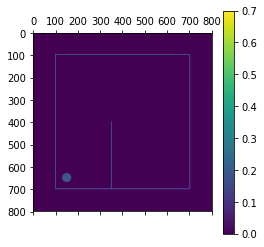

[50.0, 51.11702974325146, 54.7318139253023, 61.8033988749895, 67.28163648031882, 57.73502691896258, 52.57311121191338, 50.27541397817581, 50.27541397817581, 52.57311121191334, 57.735026918962525, 67.28163648031868, 85.06508083520401, 122.92966677871179, 240.48671723720636, 550.0, 562.287327175766, 602.0499531783257, 679.8373876248843, 740.0980012835071, 346.41016151377556, 315.4386672714802, 301.65248386905495, 301.6524838690549, 161.80339887498948, 99.99999999999994, 74.72382749323043, 61.8033988749895, 54.73181392530235, 51.11702974325146]


In [ ]:
#DEFINITION DE LA PARTIE
obstacles = []
# On ajoute les murs
obstacles.append(Segment([100,100],[100,700]))
obstacles.append(Segment([100,100],[700,100]))
obstacles.append(Segment([100,700],[700,700]))
obstacles.append(Segment([700,100],[700,700]))
# On ajoute les obstacles
#obstacles.append(Segment([600,500],[600,700]))
#obstacles.append(Segment([400,200],[400,100]))
obstacles.append(Segment([700,350],[400,350]))
#obstacles.append(Segment([400,350],[400,550]))


array_balle = [650,650]
array_trou = [650,150]
partie = Partie(array_balle,array_trou, obstacles)

partie.remplir_matrice()
plt.figure(figsize = (800,800))
im1 = plt.matshow(partie.matrice, interpolation = 'bilinear')
plt.colorbar(im1)
plt.plot([])
plt.show()
a = partie.distances()
print(a)
def fitness_function(x):
    joueur = Joueur(array_trou,array_balle,obstacles, nbre_mouvements)
    joueur.nn.transform(x)
    joueur.faire_partie()
    a = joueur.evaluate_fitness()
    return a
    
    

In [ ]:
#population = pickle.load( open( "./data/gen_fitness180.pkl", "rb" ) )
x0 = np.random.randn(N_in*N1+N2*N1+ N2*N_out)
#x0 = population.to_array()
es = pickle.load(open( "./data/last_cma_fit_easy.pkl", "rb" ) )
#es = cma.CMAEvolutionStrategy(x0,0.2)

i = 1
while True:
    print("generation : "+str(i))
    solutions = es.ask()
    population = Population(solutions, array_trou ,obstacles)
    es.tell(solutions, [-population.fitness_function(i) for i in range(len(solutions))])
    print("nb de victoires : "+str(sum([i.partie.reached_goal for i in population.liste_joueur])))
    if i%10 == 0: 
        with open("./data/gen_fitness_easy"+str(i)+".pkl", 'wb') as pickle_file:
            pickle.dump(population, pickle_file)
        #population.total_transform(array_trou, obstacles, array_balle)
        #print(" En commencant du début, meilleur fit = "+str(-max([i.fitness for i in population.liste_joueur])))
        with open("./data/last_cma_fit_easy.pkl", 'wb') as pickle_file:
            pickle.dump(es, pickle_file)
    

    
            
    es.logger.add()
    es.disp()
    i += 1
        

generation : 1
nb de victoires : 10
generation : 2
nb de victoires : 5
generation : 3
nb de victoires : 9
generation : 4
nb de victoires : 9
  434  10416 -1.000000000000000e+02 1.2e+00 1.49e-01  1e-01  1e-01 48:28.9
generation : 5
nb de victoires : 9
generation : 6
nb de victoires : 16
generation : 7
nb de victoires : 6
generation : 8
nb de victoires : 9
generation : 9
nb de victoires : 7
generation : 10
nb de victoires : 6
generation : 11
nb de victoires : 10
generation : 12
nb de victoires : 6
generation : 13
nb de victoires : 8
  443  10632 -1.000000000000000e+02 1.2e+00 1.49e-01  1e-01  1e-01 49:56.3
generation : 14
nb de victoires : 11
generation : 15
nb de victoires : 3
generation : 16
nb de victoires : 9
generation : 17
nb de victoires : 10
generation : 18


In [ ]:
print(N_in*N1+N2*N1+ N2*N_out)